**Objective: Linear regression**

I will explore a simple linear regression case using the statsmodels and pandas data reader packages.

**The context is as follows:**

- I'm a junior quantitative analyst and your desk has asked you to build a model to understand the monthly evolution of the S&P500 (normalized values).

- I'm entitled to two macro variables: the unemployment rate and the US interest rate (per month).

- I'm entitled to the trends of another index: the NASDAQ.

- I can construct moving averages of S&P500 and NASDAQ values.

- The aim is to understand how the S&P500 evolves along with the other variables.

- I am expected to explore simple linear regressions and compare iterations.

- The dataset runs from 2010 to 2023 and I will keep the last 36 months to evaluate your model.


**Objectif : Régression Linéaire**

Nous allons explorer un cas de régression linéaire simple avec les packages statsmodels et pandas data reader.

**Le contexte est le suivant:**

• Je suis un analyste quantitatif débutant et votre desk vous demande de construire un modèle pour comprendre l'évolution mensuelle du S&P500 (valeurs normalisées).

• J'ai le droit à deux variables macros: le taux de chômage et le taux d'intérêt aux USA (par mois)

• J'ai le droit aux évolutions d'un autre indice : le NASDAQ

• Je peux construire des moyennes mobiles de la valeur du S&P500 et du NASDAQ

• L'objectif est de comprendre comment le S&P500 évolue en même temps que les autres variables.

• On attend de moi d'explorer les cas de régressions linéaires simples et comparer les itérations.

• Le jeu de données va de 2010 à 2023 et je garderai les 36 derniers mois pour évaluer votre modèle.



In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import yfinance as yf
import statsmodels.api as sm
from sklearn.metrics import mean_absolute_error,r2_score,mean_squared_error
from pandas_datareader import data as pdr

In [3]:
#On va importer l'évolution mensuelle du S&P500 et du Nasdaq
index = ["^GSPC","^IXIC"]
data_index = yf.download(index,start="2010-01-01",end="2023-01-01",interval='1mo').reset_index()

#On met la date en fonction des mois, plus besoin des jours indiqués + on ne garde que valeur de clôture et date
data_index["Date"] = data_index["Date"].dt.strftime("%Y/%m")
data_index = data_index[["Date","Close"]]
data_index

data_index.columns = [v[0]+v[1].replace("^"," ") if v[1] != "" else v[0] for v in data_index.columns]

[*********************100%***********************]  2 of 2 completed


In [4]:
# On va maitenant importer les données de la FED
unemployment_rate = pdr.get_data_fred("UNRATE",start="2010-01-01",end="2023-01-01",freq="1mo").reset_index()
unemployment_rate["Date"] = unemployment_rate["DATE"].dt.strftime("%Y/%m")
unemployment_rate.drop("DATE",axis="columns",inplace=True)

interest_rate = pdr.get_data_fred("DFF", start= "2010-01-01", end= "2023-01-01", freq="1mo").resample("M").last().reset_index()
interest_rate["Date"] = interest_rate["DATE"].dt.strftime("%Y/%m")
interest_rate.drop("DATE",axis="columns",inplace=True)

#On regroupe tout
data = data_index[["Date","Close GSPC","Close IXIC"]].merge(unemployment_rate,on="Date",how="left").merge(interest_rate,on="Date",how="left")
data.drop("Date",axis="columns",inplace=True)

data["UNRATE"] = data["UNRATE"].diff()
data["DFF"] = data["DFF"].diff()
data["Close GSPC"] = data["Close GSPC"].diff()
data["Close IXIC"] = data["Close IXIC"].diff()

data.dropna(inplace=True)

/var/folders/st/kwps6pbj74j_zrv9wwqrs5z00000gn/T/ipykernel_1427/4115247103.py:6: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  interest_rate = pdr.get_data_fred("DFF", start= "2010-01-01", end= "2023-01-01", freq="1mo").resample("M").last().reset_index()


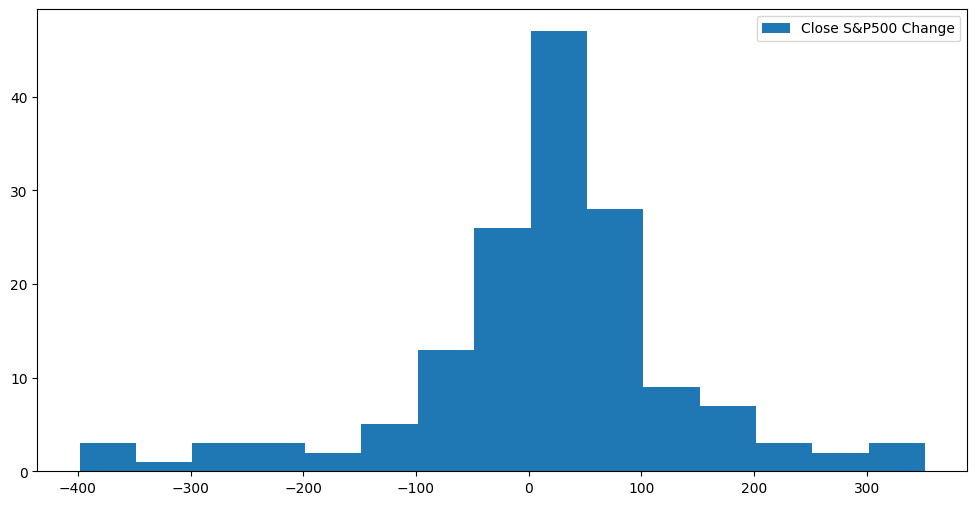

In [5]:
plt.figure(figsize= (12,6))
plt.hist(data["Close GSPC"],15,label="Close S&P500 Change")
plt.legend()
plt.show()

We can see that a normal distribution is more or less observed. Now we need to **pre-process our data**, i.e. normalize them, so that we no longer have the raw difference but **the normalized value of these differences**.

On remarque qu'on observe plus ou moins une loi normale. Maintenant, il faut **pré-processer nos données**, c'est-à-dire qu'on va les normaliser, pour ne plus avoir la différence brute mais **la valeur normalisée de ces différences**

In [6]:
from sklearn.preprocessing import StandardScaler

preprocess = StandardScaler()
preprocessed_data = preprocess.fit_transform(data)

#Le hic c'est que ce preprocessing nous renvoie un nparray, et on veut un dataframe, donc il faut le modifier:

preprocessed_data = pd.DataFrame(preprocessed_data,columns=["Close GSPC","Close IXIC","UNRATE","DFF"])
preprocessed_data

,Close GSPC,Close IXIC,UNRATE,DFF
0,0.104711,0.087268,0.045233,-0.088677
1,0.385970,0.248480,0.156519,-0.347039
2,-0.004777,0.022400,0.045233,0.428048
3,-0.943448,-0.604212,-0.288628,-0.192022
4,-0.627281,-0.472154,-0.177341,-0.657074
...,...,...,...,...
150,-1.582754,-1.472113,0.156519,-0.088677
151,-3.173350,-3.033111,-0.066054,3.735085
152,2.200540,0.840994,0.156519,-0.140349
153,1.559435,0.998758,0.045233,3.735085


In [7]:
#Maintenant, on compute les moyennes mobiles 3,6,12,24 pour chaque indice:
target = "Close GSPC"
preprocessed_data["SPX_SMA_3"] = preprocessed_data[target].rolling(3).mean()
preprocessed_data["SPX_SMA_6"] = preprocessed_data[target].rolling(6).mean()
preprocessed_data["SPX_SMA_12"] = preprocessed_data[target].rolling(12).mean()
preprocessed_data["SPX_SMA_24"] = preprocessed_data[target].rolling(24).mean()

preprocessed_data["IXIC_SMA_3"] = preprocessed_data["Close IXIC"].rolling(3).mean()
preprocessed_data["IXIC_SMA_6"] = preprocessed_data["Close IXIC"].rolling(6).mean()
preprocessed_data["IXIC_SMA_12"] = preprocessed_data["Close IXIC"].rolling(12).mean()
preprocessed_data["IXIC_SMA_24"] = preprocessed_data["Close IXIC"].rolling(24).mean()

preprocessed_data["Target"] = preprocessed_data[target]
preprocessed_data = preprocessed_data.drop(target, axis=1)
preprocessed_data.dropna(inplace=True)

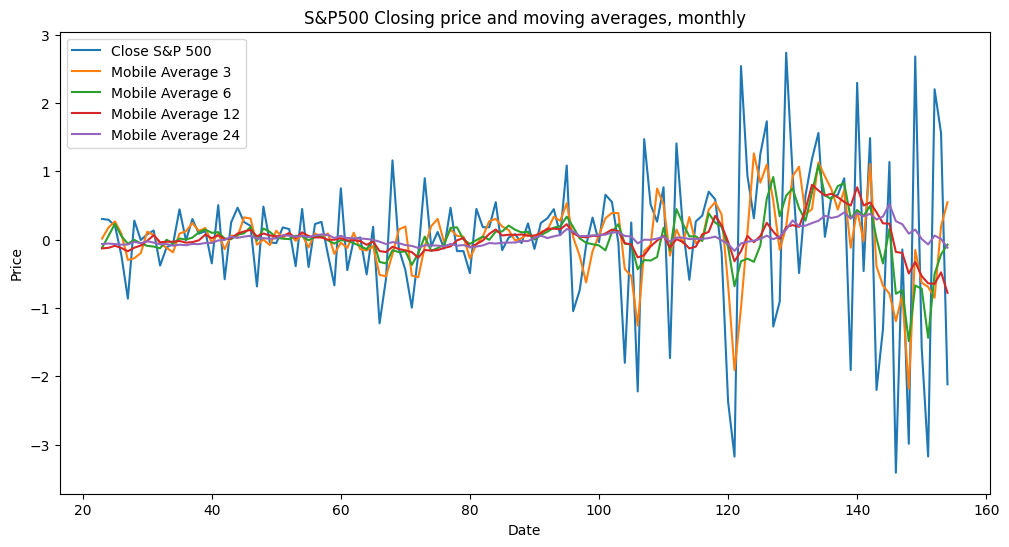

In [8]:
# On affiche les valeurs du S&P500 avec ses moyennes mobiles 


plt.figure(figsize=(12,6))
plt.plot(preprocessed_data["Target"],label="Close S&P 500")
plt.plot(preprocessed_data["SPX_SMA_3"],label="Mobile Average 3")
plt.plot(preprocessed_data["SPX_SMA_6"],label="Mobile Average 6")
plt.plot(preprocessed_data["SPX_SMA_12"],label="Mobile Average 12")
plt.plot(preprocessed_data["SPX_SMA_24"],label="Mobile Average 24")
plt.title("S&P500 Closing price and moving averages, monthly")
plt.ylabel("Price")
plt.xlabel("Date")
plt.legend()
plt.show()

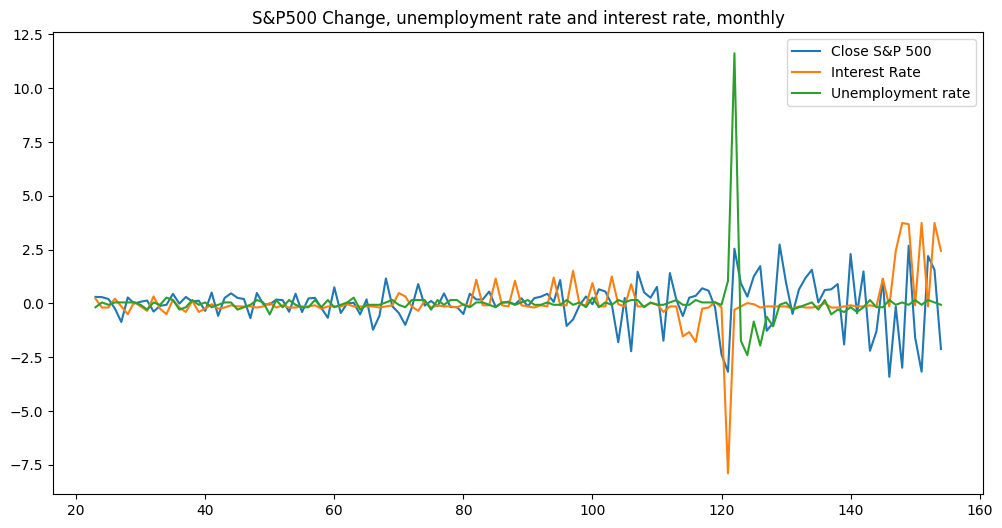

In [9]:
# On affiche les valeurs du S&P500 avec le taux de chômage et le taux d'intérêt

plt.figure(figsize=(12,6))
plt.plot(preprocessed_data["Target"],label="Close S&P 500")
plt.plot(preprocessed_data["DFF"],label= "Interest Rate")
plt.plot(preprocessed_data["UNRATE"], label="Unemployment rate")
plt.title("S&P500 Change, unemployment rate and interest rate, monthly")
plt.legend()
plt.show()

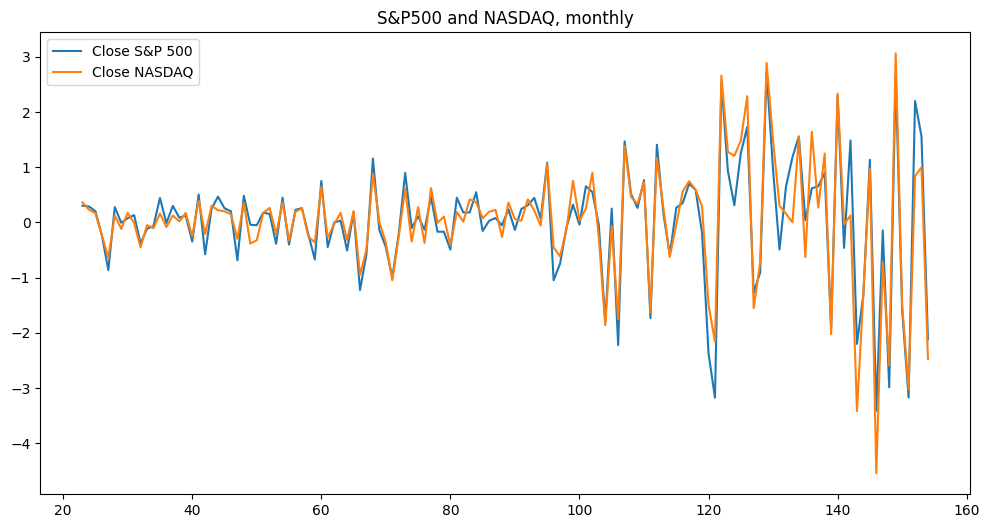

In [10]:
#Et on affiche graphiquement le S&P500 avec le Nasdaq

plt.figure(figsize=(12,6))
plt.plot(preprocessed_data["Target"],label="Close S&P 500")
plt.plot(preprocessed_data["Close IXIC"],label="Close NASDAQ")
plt.title("S&P500 and NASDAQ, monthly")
plt.legend()
plt.show()


In [11]:
preprocessed_data.corr()

,Close IXIC,UNRATE,DFF,SPX_SMA_3,SPX_SMA_6,SPX_SMA_12,SPX_SMA_24,IXIC_SMA_3,IXIC_SMA_6,IXIC_SMA_12,IXIC_SMA_24,Target
Close IXIC,1.000000,0.120808,-0.007331,0.499673,0.423634,0.300113,0.105328,0.558660,0.496809,0.375616,0.197292,0.936613
UNRATE,0.120808,1.000000,-0.072898,-0.303646,-0.129919,-0.127249,-0.101303,-0.207231,-0.090597,-0.106529,-0.088057,0.130489
DFF,-0.007331,-0.072898,1.000000,0.019530,-0.236423,-0.210407,0.113077,-0.139231,-0.347122,-0.325699,-0.081849,0.050276
SPX_SMA_3,0.499673,-0.303646,0.019530,1.000000,0.716742,0.535539,0.204179,0.901322,0.706751,0.568536,0.326661,0.504943
SPX_SMA_6,0.423634,-0.129919,-0.236423,0.716742,1.000000,0.763594,0.385024,0.643912,0.913175,0.783402,0.546502,0.444575
SPX_SMA_12,0.300113,-0.127249,-0.210407,0.535539,0.763594,1.000000,0.673593,0.470425,0.670754,0.915894,0.806096,0.321465
SPX_SMA_24,0.105328,-0.101303,0.113077,0.204179,0.385024,0.673593,1.000000,0.057958,0.205588,0.500978,0.911900,0.180461
IXIC_SMA_3,0.558660,-0.207231,-0.139231,0.901322,0.643912,0.470425,0.057958,1.000000,0.774064,0.621214,0.279969,0.465607
IXIC_SMA_6,0.496809,-0.090597,-0.347122,0.706751,0.913175,0.670754,0.205588,0.774064,1.000000,0.820030,0.469263,0.439901
IXIC_SMA_12,0.375616,-0.106529,-0.325699,0.568536,0.783402,0.915894,0.500978,0.621214,0.820030,1.000000,0.756357,0.327325


In [12]:
#Construction d'un premier modèle : délimitons X et Y en fonction de la consigne : pour l'entrainement, pas touche aux 36 derniers mois
X = preprocessed_data[["Close IXIC","SPX_SMA_3","SPX_SMA_6","SPX_SMA_12","SPX_SMA_24","UNRATE","DFF"]]
Y = preprocessed_data["Target"]

# X et Y pour l'entraînement du modèle
train_size = len(preprocessed_data) - 36 
X_train, X_test = X.iloc[:train_size], X.iloc[train_size:]

#X et Y pour le test du modèle
Y_train,Y_test = Y.iloc[:train_size], Y.iloc[train_size:]

Y_train = Y_train.squeeze()

In [13]:
X_train.shape

(96, 7)

In [27]:
#Pour la construction : module sm 
X_train = sm.add_constant(X_train)
X_test = sm.add_constant(X_test)

model = sm.OLS(Y_train,X_train).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                 Target   R-squared:                       0.902
Model:                            OLS   Adj. R-squared:                  0.894
Method:                 Least Squares   F-statistic:                     115.3
Date:                Sat, 28 Sep 2024   Prob (F-statistic):           1.55e-41
Time:                        16:03:55   Log-Likelihood:                 25.186
No. Observations:                  96   AIC:                            -34.37
Df Residuals:                      88   BIC:                            -13.86
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0154      0.020     -0.758      0.4

In [35]:
#Maintenant faisons une regression de Lasso

#Pour le train, on prend les valeurs avant les 36 derniers mois
X_train, X_test = X.iloc[:train_size], X.iloc[train_size:]
Y_train, Y_test = Y.iloc[:train_size], Y.iloc[train_size:]

#On prend sklearn pour Lasso, ça s'entraîne sur les bonnes valeurs (avant 36 derniers mois)
from sklearn.linear_model import Lasso
model = Lasso(alpha=0.1)
model.fit(X_train, Y_train)

#On crée le modèle de test à partir de l'entraînement
Y_pred = model.predict(X_test)

#On peut comparer les scores pour le train et le test
print(model.score(X_train, Y_train))
print(model.score(X_test,Y_test))

0.7953361651497306
0.8356862958369544


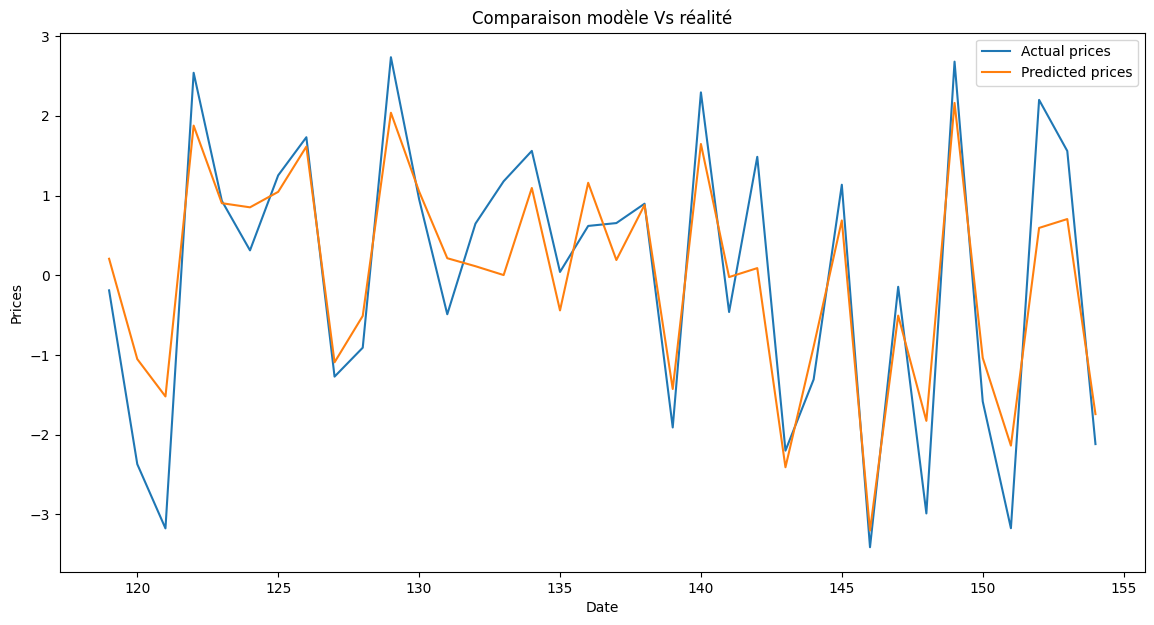

In [33]:
plt.figure(figsize=(14,7))
plt.plot(preprocessed_data.index[train_size:],Y_test.values, label = "Actual prices")
plt.plot(preprocessed_data.index[train_size:],Y_pred, label = "Predicted prices")
plt.title("Comparaison modèle Vs réalité")
plt.xlabel("Date")
plt.ylabel("Prices")
plt.legend()
plt.show()

In [41]:
params = [1, 0.5, 0.1, 0.01, 0.005, 0.001, 0.0005, 1e-4, 1e-5]

for param in params:
    model = Lasso(alpha = param)
    model.fit(X_train, Y_train)

    train_score = model.score(X_train, Y_train)
    test_score = model.score(X_test, Y_test)
    predictions = model.predict(X_test)
    test_mse = mean_squared_error(Y_test, predictions)

    print(f"Lasso alpha: {param}")
    print(f"Train R2 : {train_score}")
    print(f"predictions : {test_score}")
    print(f"test MSE : {test_mse}")
    print("")

Lasso alpha: 1
Train R2 : 0.0
predictions : -0.0002770383645589458
test MSE : 3.22186141242812

Lasso alpha: 0.5
Train R2 : 0.0
predictions : -0.0002770383645589458
test MSE : 3.22186141242812

Lasso alpha: 0.1
Train R2 : 0.7953361651497306
predictions : 0.8356862958369544
test MSE : 0.529249360598742

Lasso alpha: 0.01
Train R2 : 0.8954959221577402
predictions : 0.8591680743039617
test MSE : 0.4536152782031977

Lasso alpha: 0.005
Train R2 : 0.8966860707359022
predictions : 0.8548993274831084
test MSE : 0.4673647797253149

Lasso alpha: 0.001
Train R2 : 0.9000839009830005
predictions : 0.8319580735176134
test MSE : 0.5412578494142779

Lasso alpha: 0.0005
Train R2 : 0.9012713040547288
predictions : 0.815969417947643
test MSE : 0.5927568146426663

Lasso alpha: 0.0001
Train R2 : 0.9016967500879869
predictions : 0.7992234915310449
test MSE : 0.646694925853547

Lasso alpha: 1e-05
Train R2 : 0.9017142158407092
predictions : 0.7950914643342826
test MSE : 0.6600040576937802

